# Mining Entities and Relations

with and without LLMs

this helps with KG population tasks

## Mining Entities

### No-LLM method: Use Spacy's NER pipeline



#### Supported entity types by Spacy
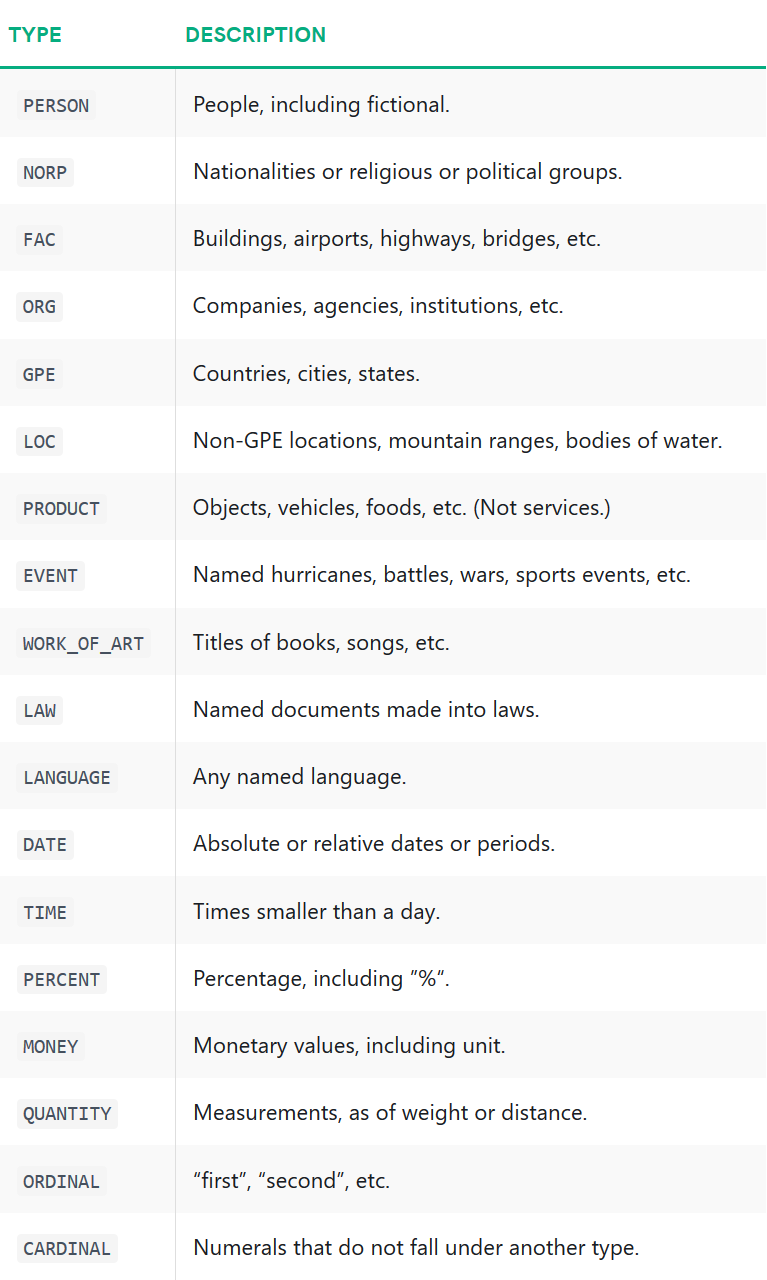



In [ ]:
! pip install spacy

In [ ]:
! spacy download en_core_web_sm

In [6]:
# Import spacy library and load one of the trained pipelines for English
import spacy
nlp = spacy.load("en_core_web_sm")

#import en_core_web_sm
#nlp = en_core_web_sm.load()

In [7]:
# method to find entities
def find_entities_with_spacy(text):
  doc = nlp(text)
  for ent in doc.ents:
    return ent.text, ent.start_char, ent.end_char, ent.label_

In [12]:
example1 = "Satya Nadella is the CEO of Microsoft"
example2 = "Guido van Rossum created Python"
example3 = "Dave Wentzel wouldn't drive a Yugo"
example4 = "Satya Nadella does not like Indian food."

In [13]:
print(find_entities_with_spacy(example1))
print()
print(find_entities_with_spacy(example2))
print()
print(find_entities_with_spacy(example3))
print()
print(find_entities_with_spacy(example4))
print()


('Satya Nadella', 0, 13, 'PERSON')

('Guido van Rossum', 0, 16, 'PERSON')

('Dave Wentzel', 0, 12, 'PERSON')

('Satya Nadella', 0, 13, 'PERSON')



### Entity extraction with gpt

In [ ]:
# install openai
!pip install openai

In [10]:
from openai import OpenAI

In [ ]:
apikey = ""

In [ ]:
class GPTEntityExtractor:

    def __init__(self):
        self.client = OpenAI(api_key = apikey) # Put here your api key)

    def extract_entities(self,text):

      skill_types = ["Persons", "Countries", "Cities", "Organizations", "Products"]

      system_prompt = f"""Write a json file with all the {', '.join(skill_types).strip()} that are explicitly mentioned in the following text. \n ### \n {text} \n ###"""

      completion = self.client.chat.completions.create(
      model="gpt-3.5-turbo",
      temperature = 0,
      messages=[
        {"role": "system", "content": "You are an entity extractor."},
        {"role": "user", "content": f"""Write a json file with all the {', '.join(skill_types).strip()} that are mentioned in the following text. \n ### \n {text} \n ###"""}
      ]
      )

      return completion.choices[0].message.content







In [ ]:
gpt_entity_extractor = GPTEntityExtractor()

In [ ]:
print(gpt_entity_extractor.extract_entities(example1))
print(gpt_entity_extractor.extract_entities(example2))
print(gpt_entity_extractor.extract_entities(example3))
print(gpt_entity_extractor.extract_entities(example4))


## Mining Relations

### No-LLM method: Extracting entity relations from text using [Luke](https://huggingface.co/docs/transformers/model_doc/luke)

### Supported relations

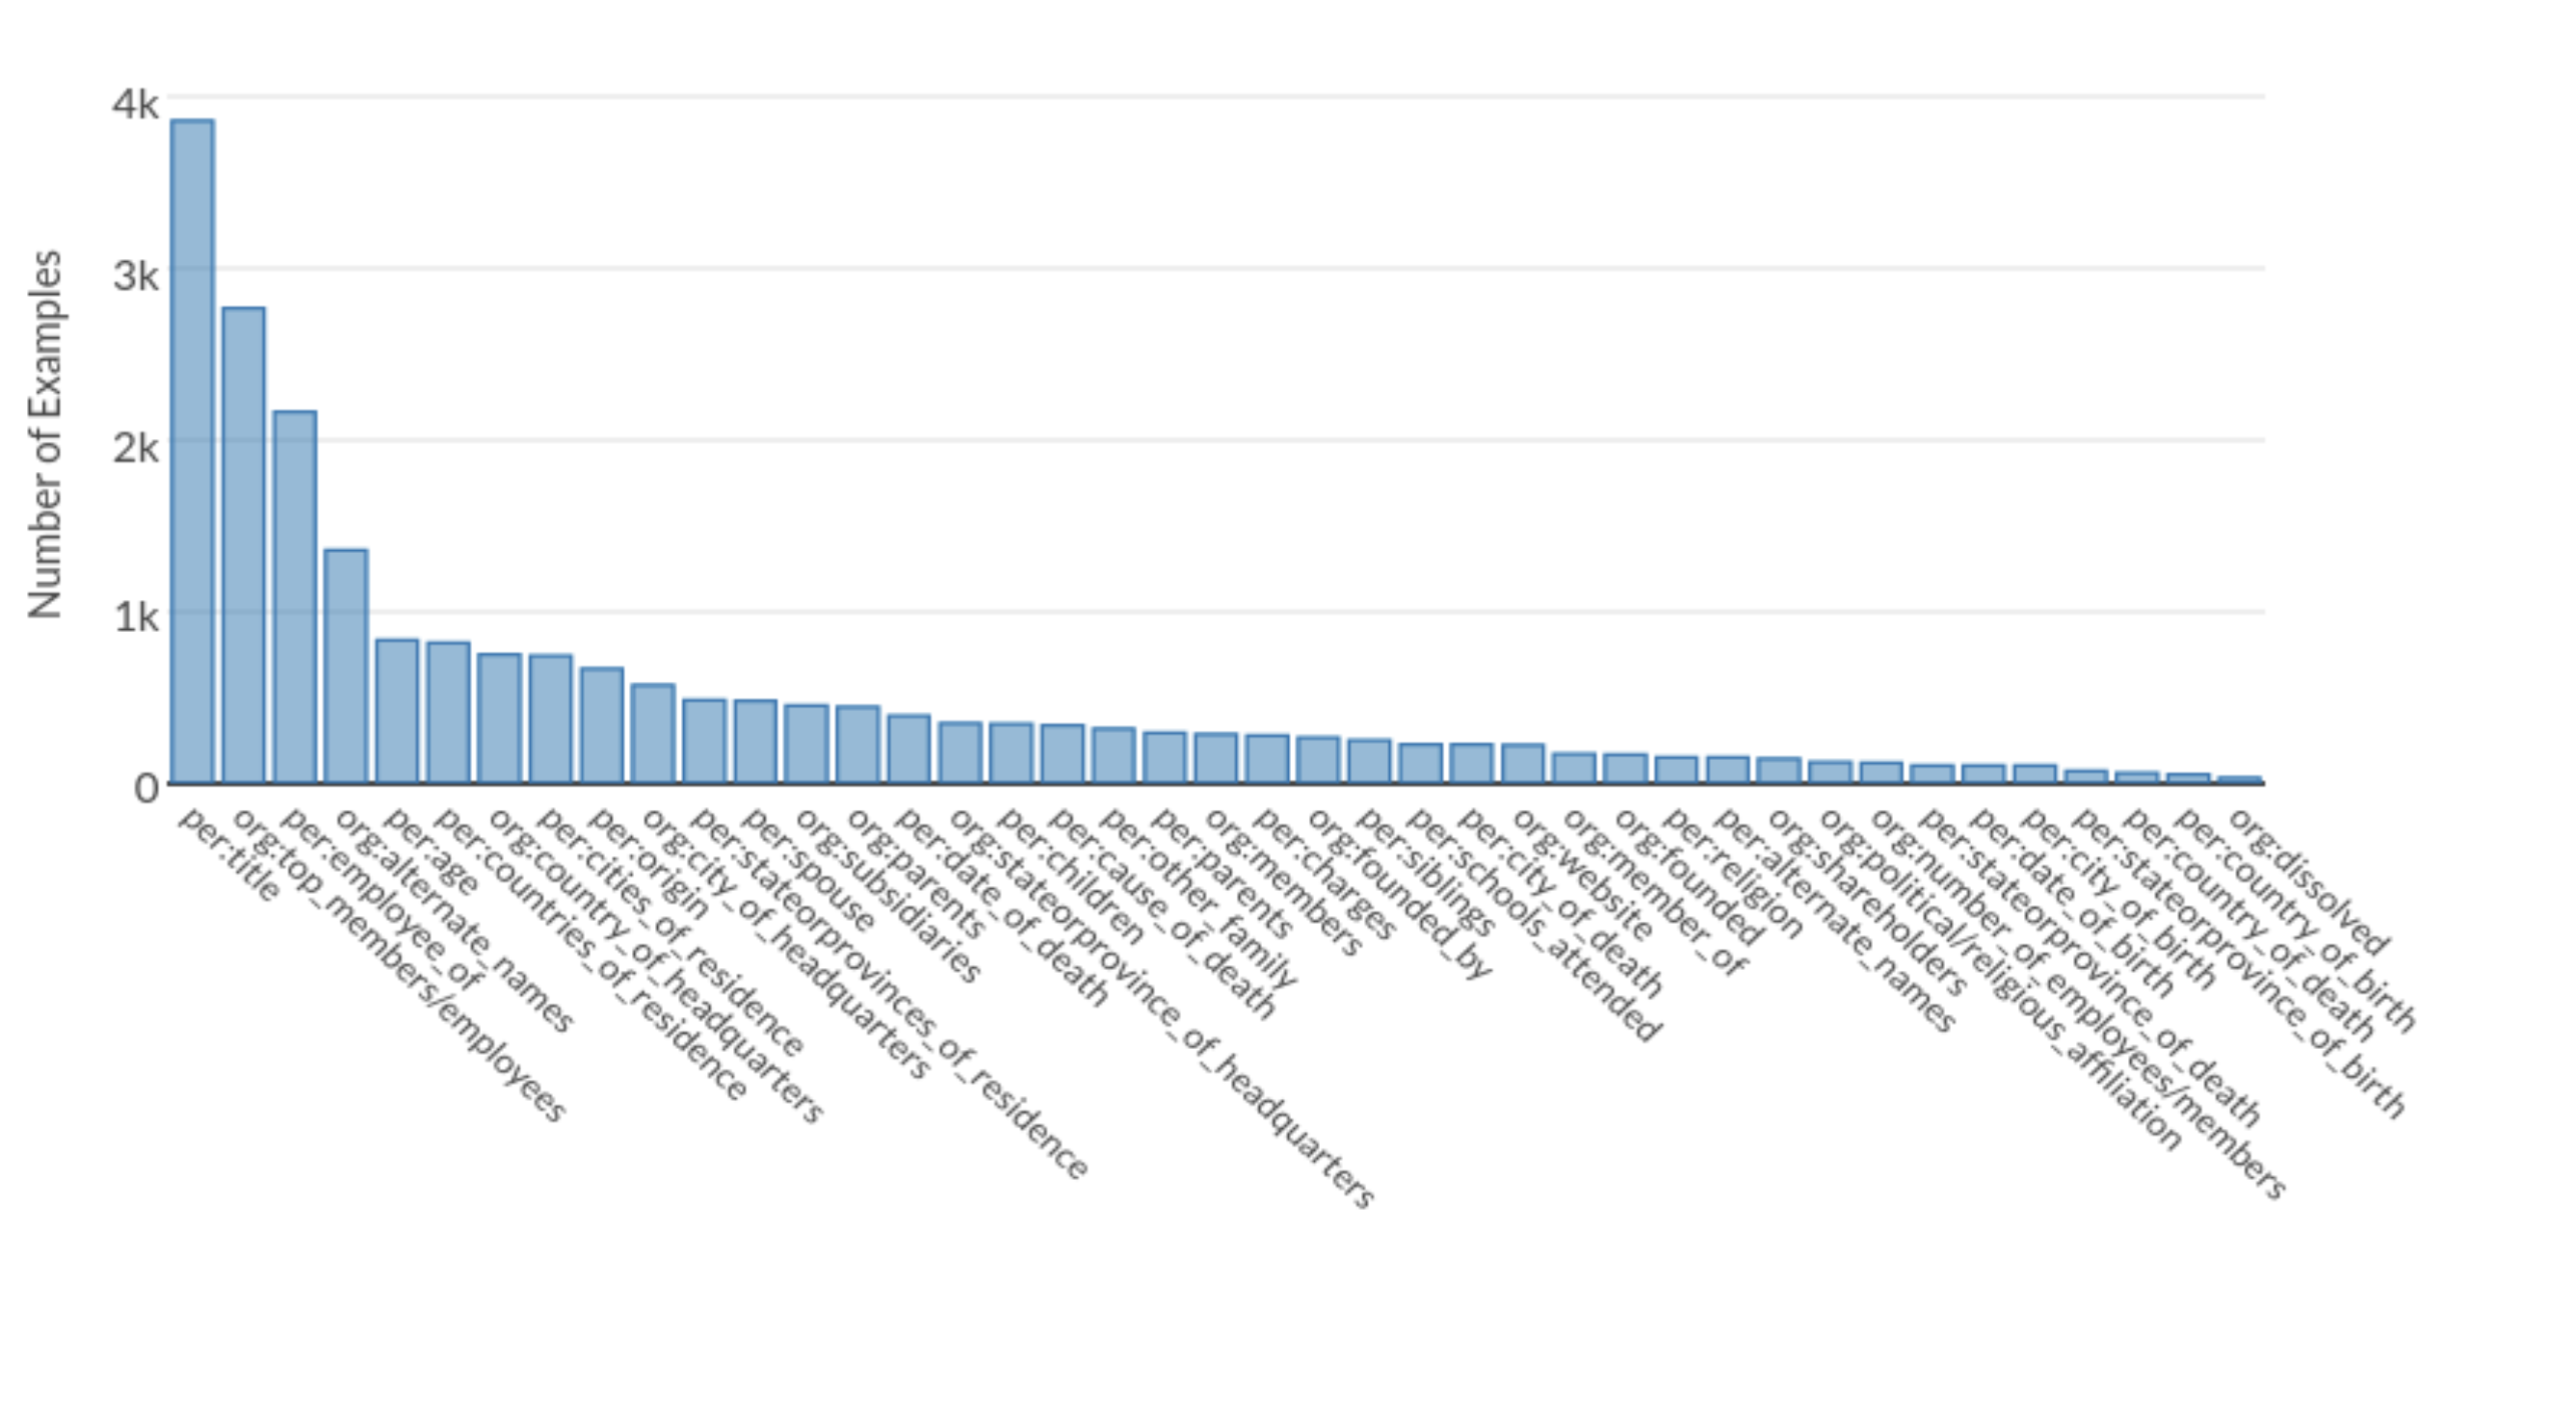

In [ ]:
! pip install transformers

In [ ]:
from transformers import LukeTokenizer, LukeForEntityPairClassification

In [ ]:
class LUKEClient:

    def __init__(self):
        self.model = LukeForEntityPairClassification.from_pretrained("studio-ousia/luke-large-finetuned-tacred")
        self.tokenizer = LukeTokenizer.from_pretrained("studio-ousia/luke-large-finetuned-tacred")


    def extract_relation(self, text, subject, object):

        subject_start = text.index(subject)
        subject_end = subject_start+len(subject)

        object_start = text.lower().index(object.lower())
        object_end = object_start + len(object)
        entity_spans = [(subject_start, subject_end),(object_start, object_end)]

        inputs = self.tokenizer(text, entity_spans=entity_spans, return_tensors="pt")
        outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_class_idx = int(logits[0].argmax())
        predicted_class_label = self.model.config.id2label[predicted_class_idx]
        return predicted_class_label


In [ ]:
luke = LUKEClient()

In [ ]:
print(luke.extract_relation("Dave lives in New Jersey", "Dave","New Jersey"))
print(luke.extract_relation("Juan was not born in Mexico.", "Juan","Mexico"))
print(luke.extract_relation("Tiktok was acquired by Oracle", "Tiktok","Oracle"))
print(luke.extract_relation("Dave got a job offer from Facebook, but he refused it", "Dave","Facebook"))

per:cities_of_residence
per:country_of_birth
org:parents
per:employee_of


### LLM method: Relation extraction with gpt

In [ ]:
class GPTRelationExtractor:

    def __init__(self):
        self.client = OpenAI(api_key = apikey) 

    def extract_relation(self,text, subj_entity, obj_entity):

      relations = ["employee_of", "city_of_residence", "country_of_birth", "organizational_parent", "unknown"]

      system_message = "You are a relation extractor who can detect and classify relations between entities in text."
      user_message = f"""
          In the following text, what is the relation that holds (or used to hold) between the entities '{subj_entity}' and '{obj_entity}'
          The relations can only be one of the following: {', '.join(relations).strip()}

          Text: {text}

          """

      completion = self.client.chat.completions.create(
      model="gpt-3.5-turbo",
      temperature = 0,
      messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
      ]
      )

      return completion.choices[0].message.content




In [ ]:
gpt_relation_extractor = GPTRelationExtractor()

In [ ]:
print(gpt_relation_extractor("Dave lives in New Jersey", "Dave","New Jersey"))
print(gpt_relation_extractor("Juan was not born in Mexico.", "Juan","Mexico"))
print(gpt_relation_extractor("Tiktok was acquired by Oracle", "Tiktok","Oracle"))
print(gpt_relation_extractor("Dave got a job offer from Facebook, but he refused it", "Dave","Facebook"))
